In [1]:
import os
import uuid
from pathlib import Path
import glob
import shutil
import json
import numpy as np
import pathlib
import pandas as pd
from collections import namedtuple
import subprocess

from xml.dom import minidom

import networkx as nx
import graphical_models
import tqdm

Make sure  https://github.com/linlinchn/gnw/raw/master/gnw-3.1b.jar is in your root directory (should be there already)

Credits: Code copied from https://github.com/yannadani/cbed/blob/main/envs/dream4.py and adjusted for modularity

Usage:
Different graphs are available in /configurations, just switch them out by setting them in the 'name' argument of {observe, intervene, knockdown}

Note: Knockdown/Knockout only generate one sample a time for the node specified (a limitation by the original Java jar code, can only be improved by adjusting that Java code and recompiling which sounds like pain)


In [57]:
def observe(samples, name='InSilicoSize10-Ecoli1'):
    network = f'configurations/{name}.xml'
    cmd = f'java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net {network} --output-net-format=1 --simulate'
    print(cmd)

    data = []
    for _ in tqdm.tqdm(range(samples)):
        subprocess.check_call(cmd.split(' '),  stderr=subprocess.DEVNULL)
        data.append(pd.read_csv(f'{name}_wildtype.tsv', sep='\t'))
    return pd.concat(data)


def intervene(samples, node, name='InSilicoSize10-Ecoli1'):
    network = f'configurations/{name}.xml'
    cmd = f'java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net {network} --output-net-format=1 --simulate'
    print(cmd)
    #subprocess.check_call(cmd.split(' '),  stderr=subprocess.DEVNULL)
    #data = pd.read_csv(f'{name}_knockouts.tsv', sep='\t')
    #return data.iloc[node]

    data = []
    for _ in tqdm.tqdm(range(samples)):
        subprocess.check_call(cmd.split(' '),  stderr=subprocess.DEVNULL)
        row = pd.read_csv(f'{name}_knockouts.tsv', sep='\t').iloc[node]
        if len(data) == 0:
            data = row
            continue
        data = pd.concat([data, row], axis=1)
    return data.T

def knockdown(samples, node, name='InSilicoSize10-Ecoli1'):
    network = f'configurations/{name}.xml'
    cmd = f'java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net {network} --output-net-format=1 --simulate'
    print(cmd)

    data = []
    for _ in tqdm.tqdm(range(samples)):
        subprocess.check_output(cmd.split(' '),  stderr=subprocess.DEVNULL)
        row = pd.read_csv(f'{name}_knockdowns.tsv', sep='\t').iloc[node]
        if len(data) == 0:
            data = row
            continue
        data = pd.concat([data, row], axis=1)
    return data.T


def get_network(xml):
    xmldoc = minidom.parse(str(xml))

    nodes = []
    var2id = {}
    for i, node in enumerate(xmldoc.getElementsByTagName('species')):
        name = node.attributes.get('id').value
        if 'void' not in name:
            nodes.append(name)
            var2id[name] = i

    A = np.zeros((len(nodes), len(nodes)))

    for node in xmldoc.getElementsByTagName('reaction'):
        # child
        child = node.getElementsByTagName('listOfProducts')[0].getElementsByTagName('speciesReference')[0].attributes.get('species').value

        #parents
        for parent in node.getElementsByTagName('modifierSpeciesReference'):
            _from = var2id[parent.attributes.get('species').value]
            _to = var2id[child]
            A[_from, _to] = 1

    return nodes, var2id, A

In [28]:
observe(samples=1000)

java -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


 40%|████      | 2/5 [00:03<00:04,  1.62s/it]


KeyboardInterrupt: 

In [4]:
nodes, var2id, A= get_network('InSilicoSize10-Ecoli1.xml')
nodes, var2id, A

(['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10'],
 {'G1': 0,
  'G2': 1,
  'G3': 2,
  'G4': 3,
  'G5': 4,
  'G6': 5,
  'G7': 6,
  'G8': 7,
  'G9': 8,
  'G10': 9},
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]))

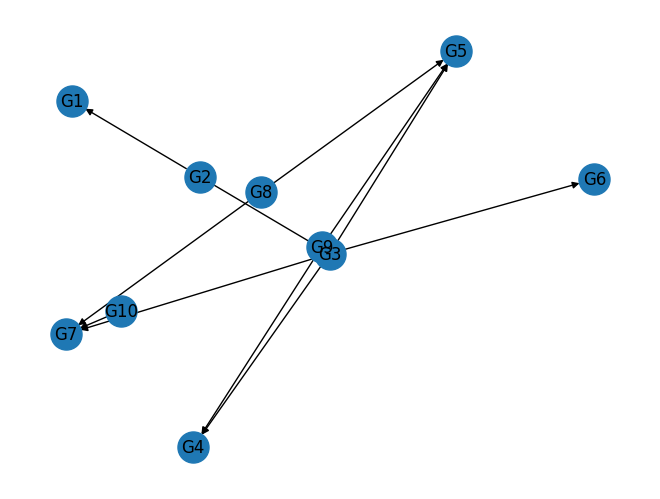

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.DiGraph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, labels=mylabels, with_labels=True, arrows=True)
    plt.show()
show_graph_with_labels(A, {i:n for i, n in enumerate(nodes)})

In [33]:
intervene(samples=3,node=1) #only one sample at a time

java -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


,1,1,1
G1,1.006480,0.947131,0.992890
G2,0.000000,0.000000,0.000000
G3,1.065632,0.968489,1.016723
G4,0.361947,0.385784,0.383833
G5,0.805663,0.818554,0.821390
G6,0.946197,1.059602,1.050192
G7,0.094041,0.067831,0.090023
G8,1.021529,0.972175,1.024322
G9,1.001083,1.003082,1.022937
G10,0.985576,1.055954,1.018665


In [37]:
knockdown(samples=3,node=1) #only one sample at a time

java -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10
1,0.105238,0.488415,0.158705,0.208633,0.834462,0.598243,0.367743,0.967029,1.045481,0.979435
1,0.130518,0.519431,0.138135,0.252482,0.786066,0.866240,0.259578,0.967666,0.933389,1.032870
1,0.113364,0.504226,0.197044,0.272286,0.831851,0.909207,0.284573,0.979314,1.054268,1.004441


## Example export

In [41]:
from pathlib import Path
Path("exports").mkdir(parents=True, exist_ok=True)

In [42]:
name='InSilicoSize10-Ecoli1'
export_path = f"exports/{name}"
Path(export_path).mkdir(parents=True, exist_ok=True)

In [43]:
nodes, var2id, A = get_network(f'{name}.xml')
nodes, var2id, A

(['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10'],
 {'G1': 0,
  'G2': 1,
  'G3': 2,
  'G4': 3,
  'G5': 4,
  'G6': 5,
  'G7': 6,
  'G8': 7,
  'G9': 8,
  'G10': 9},
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]]))

In [54]:
n = 1000
observational = observe(n, name=name)
observational.to_csv(export_path + "/observational.csv")
observational

java -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 1000/1000 [37:22<00:00,  2.24s/it]   


,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10
0,0.036987,1.084981,0.057574,0.115111,0.958768,0.052229,0.419390,0.996986,1.025739,1.001886
0,0.082038,1.021724,0.078891,0.177624,0.973461,0.273029,0.346893,1.054638,0.952767,1.030353
0,0.053333,1.044527,0.057592,0.118682,0.947055,0.100233,0.397086,1.069168,1.031705,1.028072
0,0.062435,1.146449,0.037438,0.117482,0.931446,0.078093,0.450752,0.991235,0.985956,1.021735
0,0.050235,1.057066,0.068328,0.176691,0.880554,0.193167,0.485350,0.908568,1.005502,1.040372
...,...,...,...,...,...,...,...,...,...,...
0,0.068350,0.967772,0.070901,0.142725,0.855352,0.232320,0.407476,0.984777,0.948127,1.131123
0,0.070635,1.030820,0.054420,0.140790,0.979580,0.134881,0.417179,1.124319,1.001991,1.072396
0,0.065808,0.978618,0.062789,0.167327,0.906690,0.220082,0.373628,0.997415,1.047158,1.033510
0,0.077279,1.048709,0.068122,0.193985,0.901050,0.257057,0.383720,0.945458,0.967692,0.939485


In [59]:
n = 100
for i in range(10):
    knockdowns = knockdown(samples=n, node=i, name=name)
    knockdowns.to_csv(export_path + f"/knockdowns_{i}.csv")


java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 100/100 [02:08<00:00,  1.28s/it]


java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 100/100 [02:07<00:00,  1.27s/it]


java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


java -Djava.awt.headless=true -jar gnw-3.1b.jar -c settings.txt --input-net configurations/InSilicoSize10-Ecoli1.xml --output-net-format=1 --simulate


100%|██████████| 100/100 [02:08<00:00,  1.28s/it]
